In [1]:
import numpy as np
import  pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

plt.style.use("seaborn-whitegrid")
plt.rcParams["font.size"] = 14

In [2]:
# Use for all the same features
data = pd.read_csv("Cleaned_2014.csv")
data2 = pd.read_csv("Cleaned_2015.csv")
data3 = pd.read_csv("Cleaned_2016.csv")
data4 = pd.read_csv("Cleaned_2017.csv")
data5= pd.read_csv("Cleaned_2018.csv")

a = list(set(list(data)[1:]).intersection(list(data2)[1:]))
b = list(set(list(a)).intersection(list(data3)[1:]))
c = list(set(list(b)).intersection(list(data4)[1:]))
d = list(set(list(c)).intersection(list(data5)[1:]))

data_price = data.loc[:, ["2015 PRICE VAR [%]"]]
data_price2 = data2.loc[:, ["2016 PRICE VAR [%]"]]
data_price3 = data3.loc[:, ["2017 PRICE VAR [%]"]]
data_price4 = data4.loc[:, ["2018 PRICE VAR [%]"]]
data_price5 = data5.loc[:, ["2019 PRICE VAR [%]"]]

"""a = []
for i in list(data):
  if i in list(data2) and i in list(data3) and i in list(data4) and i in list(data5):
      a.append(i)"""

data = data[d[1:]].join(data_price).rename(columns={"2015 PRICE VAR [%]":"PRICE VAR [%]"})
data2 = data2[d[1:]].join(data_price2).rename(columns={"2016 PRICE VAR [%]":"PRICE VAR [%]"})
data3 = data3[d[1:]].join(data_price3).rename(columns={"2017 PRICE VAR [%]":"PRICE VAR [%]"})
data4 = data4[d[1:]].join(data_price4).rename(columns={"2018 PRICE VAR [%]":"PRICE VAR [%]"})
data5 = data5[d[1:]].join(data_price5).rename(columns={"2019 PRICE VAR [%]":"PRICE VAR [%]"})

df_list = [data,data2,data3,data4,data5]
#Concatenate all df to one to use it for the ML_tool
df = pd.concat([data,data2,data3,data4,data5])

#df.to_csv("df.csv")
#Make a pair plot to show hot they are connected, It takes big amounts of computational power to do it for all but some can be calculated
#for i in df_list:
    #sns.pairplot(i.iloc[:,30:], hue="Class")

In [3]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import preprocessing, neighbors
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA, QuadraticDiscriminantAnalysis as QDA

data = pd.read_csv("df.csv")

x_data = data.drop(["Class", "PRICE VAR [%]"],axis=1)
y_data = data["Class"]
MinMaxScaler = preprocessing.MinMaxScaler()
X_data_minmax = MinMaxScaler.fit_transform(x_data)
data = pd.DataFrame(X_data_minmax,columns=list(x_data))

#For predicting future sell buy hold. It makes more sense to not shuffle the values. Since the stock price changes over time and we want to predict the future values
X_train, X_test, y_train, y_test = train_test_split(data, y_data, test_size=0.3, random_state = 0)
#TODO should we add shuffle to false -> affecting the prediction of the data

MinMaxScaler.fit(X_train)
X_train = MinMaxScaler.fit_transform(X_train)
X_test = MinMaxScaler.fit_transform(X_test)
#We could choose with neighbors.KNeighborsClassifier(n_neighbors=#) the amount of neighbors but it decides to choose the best one by itself, if we try to add a number it is always worse than the default
#knn_clf=KNeighborsClassifier() #by using KNN we get a score of 0.65, but using SVC we have 0.85 a huge improvement
print("Number of train elements: " + str(len(X_train)))
print("Number of test elements: " + str(len(X_test)))

Number of train elements: 15374
Number of test elements: 6590


Text(0, 0.5, 'Relative Feature Importance')

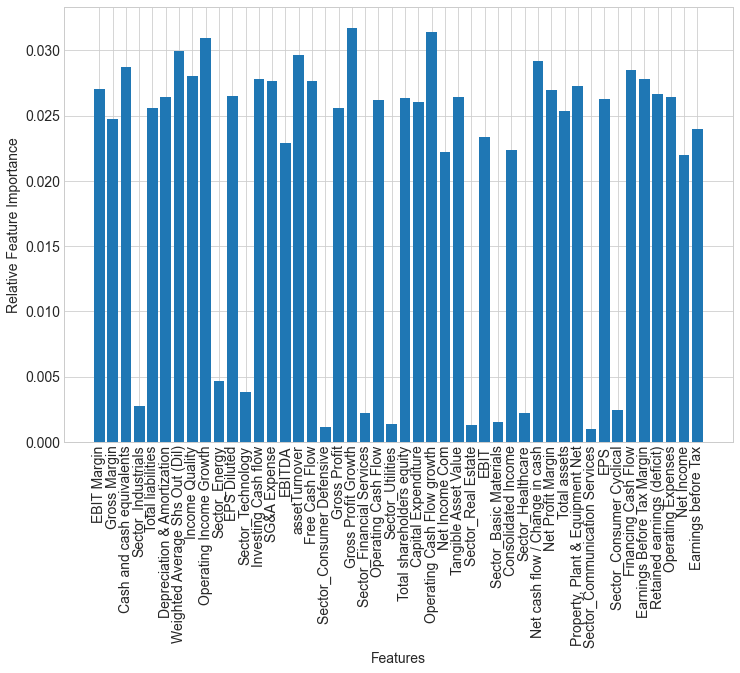

In [4]:
#See which classes are the most important for the RandomForest
forest = RandomForestClassifier(random_state=1)
forest.fit(X_train, y_train)
feat_labels = data.columns[:-1]
importance = forest.feature_importances_
feat_imp = np.sort(importance)[::-1]
sum_feat_imp = np.cumsum(feat_imp)
plt.figure(figsize=(12,8))
plt.bar(range(len(importance)-1), importance[1:], align="center")
plt.xticks(range(len(importance)-1), list(data)[1:], rotation=90)
plt.xlabel("Features")
plt.ylabel("Relative Feature Importance")

In [5]:
from sklearn.feature_selection import SelectFromModel
#import xgboost
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import RFECV
#xgb = xgboost.XGBClassifier(max_depth=10, n_estimators=1000)
m = RFECV(RandomForestClassifier(), scoring="accuracy")
mlp = MLPClassifier(random_state=0)
randomForest = RandomForestClassifier(random_state=0, class_weight="balanced")
algonames = ["M","QDA", "KNN", "SVC", "SVC_Poly", "LDA", "Random Forest", "Multilayer Perception"]
counter = 0
knn = KNeighborsClassifier()
svc = SVC(random_state=0, class_weight="balanced")
svc_poly =SVC(kernel="poly", random_state=0, class_weight="balanced")
lda = LDA(solver="lsqr")
qda = QDA()
options= [m, qda, knn, svc, svc_poly, lda, randomForest, mlp]
for i in options:
    i.fit(X_train,y_train)
    ypred=i.predict(X_test)
    result = confusion_matrix(y_test, ypred)
    print("Confusion Matrix {}:".format(algonames[counter]))
    print(result)
    result1 = classification_report(y_test, ypred)
    print("Classification Report:",)
    print (result1)
    result2 = accuracy_score(y_test,ypred)
    print("Accuracy: {}".format(algonames[counter]),result2)
    disp = ConfusionMatrixDisplay(confusion_matrix=result,
                                  display_labels=i.classes_)
    disp.plot(cmap="YlGn")
    disp.ax_.set_title(algonames[counter]+", Score: "+str(round(result2, 4)))
    counter+=1

    #plot_confusion_matrix(i, X_test, y_test, cmap="YlGn", normalize="pred")

KeyboardInterrupt: 

In [ ]:

#https://www.geeksforgeeks.org/logistic-regression-using-statsmodels/
